As the first step we import the packages and functions we will be using, set up the plot settings, logging, and set a random seed for the results to be consistent every time the code is run.

In [1]:
import sklearn
import os
import requests
import datetime
import numpy as np
import pandas as pd
import pandasql
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from scipy import stats
from datetime import date, timedelta
from pandas.plotting import scatter_matrix

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore")

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

np.random.seed(42)


C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


The publicly available data in this analysis comes from the St Louis Federal Reserve at: https://fred.stlouisfed.org/
I use the API to get the data but there are ways to download the data in spreadsheet format as well. If you would rather skip past the data acquisition and cleaning steps, you can also find the clean dataset used for EDA and Modeling in datasets/recession/processed_df.csv of my GitHub. If you are going to use the API to follow along, you need to create and set an environment variable FED_API_KEY to the API Key you get at:

https://research.stlouisfed.org/docs/api/api_key.html

I do all this to keep my API Key secure while being able to share my Jupyter notebook publicly on GitHub.

We are now ready to start.

First, let's grab the API Key from the Environment Variable. 

In [2]:
fed_api_key = os.environ.get("FED_API_KEY")

Next, let's make requests for monthly recession, monthly unemployment and daily yield spread (10yr - 3mo treasury rate) data.

In [3]:
logger.info('Sending out API requests')

#Recessions Data Request
try:
    USREC_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=USREC&api_key=%s&file_type=json'%fed_api_key
    USREC = requests.get(USREC_URL)
    logger.info('Received recession data')
except:
    logger.error('Failed to receive recession data response')

#Unemployment Data Request
try:
    UNRATE_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key=%s&file_type=json'%fed_api_key
    UNRATE = requests.get(UNRATE_URL)
    logger.info('Received unemployment data')
except:
    logger.error('Did not receive unemployment data response')

#Yield Spread Data Request
try:
    YIELD_SPREAD_URL = 'https://api.stlouisfed.org/fred/series/observations?series_id=T10Y3M&api_key=%s&file_type=json'%fed_api_key
    YIELD_SPREAD = requests.get(YIELD_SPREAD_URL)
    logger.info('Received yield spread data')
except:
    logger.error('Did not receive yield spread data response')


if USREC.status_code == 200 and UNRATE.status_code == 200 and YIELD_SPREAD.status_code == 200:
    logger.info('Received all 3 dataset responses')
else:
    logger.error('Did not receive all the required dataset responses')

INFO:__main__:Sending out API requests
INFO:__main__:Received recession data
INFO:__main__:Received unemployment data
INFO:__main__:Received yield spread data
INFO:__main__:Received all 3 dataset responses


We now have 3 response objects from the Fed site with the data we need. Let's load them as JSON objects.

In [4]:
USREC_JSON = (USREC.json())
UNRATE_JSON = (UNRATE.json())
YIELD_SPREAD_JSON = (YIELD_SPREAD.json())


Let's take a look at one of these to get a feel for the structure of the JSON object (I'm attaching an image here because otherwise Jupyter will output the entire dataset on GitHub)

![json.PNG](images/recession/json.PNG)

We can see that the JSON object contains a dictionary. Dictionaries are a Python data type that hold a collection of key value pairs. We are looking for the "observations" key, whose value is a list of other dictionaries. You can think of each dictionary in this list as a row of data. Let's get these dictionaries into the format we know and love, pandas dataframes.

In [5]:
USREC_DF = pd.DataFrame(USREC_JSON['observations'])
UNRATE_DF = pd.DataFrame(UNRATE_JSON['observations'])
YIELD_SPREAD_DF = pd.DataFrame(YIELD_SPREAD_JSON['observations'])

#save recessions dataframe as csv
#USREC_DF.to_csv(r'datasets\recession\recessions_data.csv', index = False)
#save unemployment dataframe as csv
#UNRATE_DF.to_csv(r'datasets\recession\unemployment_data.csv', index = False)
#save yield spread data as csv
#YIELD_SPREAD_DF.to_csv(r'datasets\recession\spread_data.csv', index = False)


Now let's look at each one starting with the recessions data

In [6]:
USREC_DF

,realtime_start,realtime_end,date,value
0,2020-05-28,2020-05-28,1854-12-01,1
1,2020-05-28,2020-05-28,1855-01-01,0
2,2020-05-28,2020-05-28,1855-02-01,0
3,2020-05-28,2020-05-28,1855-03-01,0
4,2020-05-28,2020-05-28,1855-04-01,0
...,...,...,...,...
1980,2020-05-28,2020-05-28,2019-12-01,0
1981,2020-05-28,2020-05-28,2020-01-01,0
1982,2020-05-28,2020-05-28,2020-02-01,0
1983,2020-05-28,2020-05-28,2020-03-01,0


Here we see we have data that starts on Dec 1st 1854. For each month, we have a value of 1 or 0 which tells us whether there was a recession that month or not. Let's look at the unemployment rate dataset next.

In [7]:
UNRATE_DF

,realtime_start,realtime_end,date,value
0,2020-05-28,2020-05-28,1948-01-01,3.4
1,2020-05-28,2020-05-28,1948-02-01,3.8
2,2020-05-28,2020-05-28,1948-03-01,4.0
3,2020-05-28,2020-05-28,1948-04-01,3.9
4,2020-05-28,2020-05-28,1948-05-01,3.5
...,...,...,...,...
863,2020-05-28,2020-05-28,2019-12-01,3.5
864,2020-05-28,2020-05-28,2020-01-01,3.6
865,2020-05-28,2020-05-28,2020-02-01,3.5
866,2020-05-28,2020-05-28,2020-03-01,4.4


Here we see we have data that starts on Jan 1st 1948. For each month, we have a decimal that tells us the unemployment percentage that month. Finally, Let's look at the yield spread.

In [8]:
YIELD_SPREAD_DF

,realtime_start,realtime_end,date,value
0,2020-05-28,2020-05-28,1982-01-04,2.32
1,2020-05-28,2020-05-28,1982-01-05,2.24
2,2020-05-28,2020-05-28,1982-01-06,2.43
3,2020-05-28,2020-05-28,1982-01-07,2.46
4,2020-05-28,2020-05-28,1982-01-08,2.50
...,...,...,...,...
10013,2020-05-28,2020-05-28,2020-05-21,0.56
10014,2020-05-28,2020-05-28,2020-05-22,0.54
10015,2020-05-28,2020-05-28,2020-05-25,.
10016,2020-05-28,2020-05-28,2020-05-26,0.55


We see that we have data starting on Jan 4th, 1982. We have a decimal representing the percent daily yield spread (not including weekends) which is found by taking the interest rate of 10yr treasury bonds on that date and subtracting the interest of the 3mo treasury bonds.

We notice that we don't need realtime_start and realtime_end columns, so let's make dataframes with just the date and value columns

In [9]:

USREC_DF_FINAL = USREC_DF[['date','value']]
UNRATE_DF_FINAL = UNRATE_DF[['date','value']]
YIELD_SPREAD_DF_FINAL = YIELD_SPREAD_DF[['date','value']]


Let's also rename the value columns with their proper names to prevent confusion when generating the consolidated dataframe

In [10]:

USREC_DF_FINAL['recession'] = USREC_DF_FINAL['value']
USREC_DF_FINAL = USREC_DF_FINAL.drop(columns=['value'])

UNRATE_DF_FINAL['unemployment'] = UNRATE_DF_FINAL['value']
UNRATE_DF_FINAL = UNRATE_DF_FINAL.drop(columns=['value'])

YIELD_SPREAD_DF_FINAL['spread'] = YIELD_SPREAD_DF_FINAL['value']
YIELD_SPREAD_DF_FINAL = YIELD_SPREAD_DF_FINAL.drop(columns=['value'])

At this point, we have two issues with the yield spread data. First, some of the days don't have a yield spread and have a string with a period as the value instead. Here is the issue:

In [11]:
YIELD_SPREAD_DF_FINAL.loc[YIELD_SPREAD_DF_FINAL['spread']=='.']

,date,spread
29,1982-02-12,.
30,1982-02-15,.
69,1982-04-09,.
105,1982-05-31,.
130,1982-07-05,.
...,...,...
9912,2020-01-01,.
9925,2020-01-20,.
9945,2020-02-17,.
9984,2020-04-10,.


After exploring the issue further I found out these dates match up with Bank Holidays when the market is closed. We are going to get rid of these datapoints since we do not want bank holidays in the data set.

In [12]:
# Get names of indexes for which column spread has a value of '.'
missing_yield_index = YIELD_SPREAD_DF_FINAL[YIELD_SPREAD_DF_FINAL['spread'] == '.' ].index
 
# Delete these row indexes from dataFrame
YIELD_SPREAD_DF_FINAL.drop(missing_yield_index, inplace=True)

Let's check if those observations are gone from the dataset:

In [13]:
YIELD_SPREAD_DF_FINAL.loc[YIELD_SPREAD_DF_FINAL['spread']=='.']

,date,spread


The second issue is that yield spread data is daily, while the other datasets are monthly. So, let's create a new monthly yield spread dataframe by finding the average yield spread for each month. 

In [14]:
#set the date column to be datetime
YIELD_SPREAD_DF_FINAL["date"] = pd.to_datetime(YIELD_SPREAD_DF_FINAL['date'])
#make a datetime index for running the monthly mean function
YIELD_SPREAD_DF_FINAL.index = YIELD_SPREAD_DF_FINAL['date']
#set the spread column to float
YIELD_SPREAD_DF_FINAL["spread"] = YIELD_SPREAD_DF_FINAL.spread.astype(float)
#create monthly dataframe
YIELD_SPREAD_DF_MONTHLY = YIELD_SPREAD_DF_FINAL.resample('M').mean()

#recreate the date column from the index
YIELD_SPREAD_DF_MONTHLY['date'] = YIELD_SPREAD_DF_MONTHLY.index.values
#reset the index to not longer be based on datetime
YIELD_SPREAD_DF_MONTHLY= YIELD_SPREAD_DF_MONTHLY.reset_index(drop=True)

In [15]:
YIELD_SPREAD_DF_MONTHLY

,spread,date
0,1.676000,1982-01-31
1,0.146111,1982-02-28
2,0.546522,1982-03-31
3,0.527143,1982-04-30
4,0.908500,1982-05-31
...,...,...
456,0.205238,2020-01-31
457,-0.040526,2020-02-29
458,0.574545,2020-03-31
459,0.519524,2020-04-30


Unfortunately, the mean function sets the date column to be the end of the month. For our final dataframe join to work we need the date column to be the beginning of the month instead (to match the other 2 dataframes). I create the following function to apply to the date column:

In [16]:
def get_first_day(dt, d_years=0, d_months=0):
    # d_years, d_months are "deltas" to apply to dt
    y, m = dt.year + d_years, dt.month + d_months
    a, m = divmod(m-1, 12)
    return datetime.date(y+a, m+1, 1)

Let's write a quick unit test for this function, we will pass 12/23/2019 into the function and make sure the expected value of 12/1/2019 is output.

In [17]:
import unittest

class TestGetFirstDay(unittest.TestCase):

    def test_get_first_day(self):
        self.assertEqual(get_first_day(datetime.date(2019, 12, 23)), datetime.date(2019, 12, 1))

test = TestGetFirstDay()

try:
    test.test_get_first_day()
    print('passed')
except AssertionError:
    print('failed')

passed


Now, let's apply the function.

In [18]:
YIELD_SPREAD_DF_MONTHLY['date'] = YIELD_SPREAD_DF_MONTHLY['date'].apply(get_first_day)

In [19]:
YIELD_SPREAD_DF_MONTHLY

,spread,date
0,1.676000,1982-01-01
1,0.146111,1982-02-01
2,0.546522,1982-03-01
3,0.527143,1982-04-01
4,0.908500,1982-05-01
...,...,...
456,0.205238,2020-01-01
457,-0.040526,2020-02-01
458,0.574545,2020-03-01
459,0.519524,2020-04-01


Looks like we're finally ready to join the 3 datasets into 1!

In [20]:
#INNER JOIN DFS ON DATE FOR SINGLE UNIFIED DATAFRAME
DF_JOIN_1 = pd.merge(USREC_DF_FINAL,UNRATE_DF_FINAL, on='date')
DF_JOIN_1["date"] = pd.to_datetime(DF_JOIN_1['date'])
YIELD_SPREAD_DF_MONTHLY["date"] = pd.to_datetime(YIELD_SPREAD_DF_MONTHLY['date'])
DF_RAW = pd.merge(DF_JOIN_1,YIELD_SPREAD_DF_MONTHLY, on = 'date')

#save raw dataframe
#DF_RAW.to_csv(r'datasets\recession\raw_df.csv', index = False)


Let's take a look:

In [21]:
DF_RAW

,date,recession,unemployment,spread
0,1982-01-01,1,8.6,1.676000
1,1982-02-01,1,8.9,0.146111
2,1982-03-01,1,9.0,0.546522
3,1982-04-01,1,9.3,0.527143
4,1982-05-01,1,9.4,0.908500
...,...,...,...,...
455,2019-12-01,0,3.5,0.297619
456,2020-01-01,0,3.6,0.205238
457,2020-02-01,0,3.5,-0.040526
458,2020-03-01,0,4.4,0.574545


Now, let's look at the data types of each column.

In [22]:
DF_RAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          460 non-null    datetime64[ns]
 1   recession     460 non-null    object        
 2   unemployment  460 non-null    object        
 3   spread        460 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.0+ KB


Date and spread columns look reasonable but let's change the recession type to int and unemployment to a float.

In [23]:
DF_RAW["recession"] = DF_RAW.recession.astype(int)
DF_RAW["unemployment"] = DF_RAW.unemployment.astype(float)


In [24]:
DF_RAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          460 non-null    datetime64[ns]
 1   recession     460 non-null    int32         
 2   unemployment  460 non-null    float64       
 3   spread        460 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 16.2 KB


Since the intent of this exercise is to see whether we can forecast a recession in the future by using the unemployment rate and yield spread as explantatory variables at present, let's reengineer our outcome variable as a recession within 1 year (from the date of the unemployment and spread data point), recession within 2 years, recession within 3 years, and recession within 4 years. The following code is a bit complicated, but it does what we need in terms of getting us the outcome variable we are looking for. You'll notice I make use of the pandasql package here which allows me to write SQL statements to perform some dataframe manipulations which would require more complicated loops otherwise.

In [25]:
#create depended/outcome variables, for recession within 1, 2, 3 and 4 years

recessions = DF_RAW[DF_RAW['recession'] == 1]
recession_dates = recessions[["date"]]
recession_dates['one_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=1))
recession_dates['two_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=2))
recession_dates['three_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=3))
recession_dates['four_year_before_rec'] = (recession_dates["date"] - pd.DateOffset(years=4))

one_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.one_year_before_rec);", globals())
two_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.two_year_before_rec);", globals())
three_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.three_year_before_rec);", globals())
four_year_rec = pandasql.sqldf("select date, 1 from DF_RAW t where exists (select 1 from recession_dates t2 where t.date < t2.date and t.date >= t2.four_year_before_rec);", globals())

one_year_rec = one_year_rec.rename(columns={"1":"recession_within_1yr"})
two_year_rec = two_year_rec.rename(columns={"1":"recession_within_2yr"})
three_year_rec = three_year_rec.rename(columns={"1":"recession_within_3yr"})
four_year_rec = four_year_rec.rename(columns={"1":"recession_within_4yr"})

one_year_rec["date"] = pd.to_datetime(one_year_rec['date'])
two_year_rec["date"] = pd.to_datetime(two_year_rec['date'])
three_year_rec["date"] = pd.to_datetime(three_year_rec['date'])
four_year_rec["date"] = pd.to_datetime(four_year_rec['date'])

#left join to the main dataframe
DF_PROCESSED = pd.merge(DF_RAW,one_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,two_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,three_year_rec, on='date',how='left')
DF_PROCESSED = pd.merge(DF_PROCESSED,four_year_rec, on='date',how='left')

#fill the missing values with 0 (which means there was no recession)
DF_PROCESSED["recession_within_1yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_within_2yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_within_3yr"].fillna(0, inplace = True) 
DF_PROCESSED["recession_within_4yr"].fillna(0, inplace = True) 

#change type of newly created dependent variables to int
DF_PROCESSED["recession_within_1yr"] = DF_PROCESSED.recession_within_1yr.astype(int)
DF_PROCESSED["recession_within_2yr"] = DF_PROCESSED.recession_within_2yr.astype(int)
DF_PROCESSED["recession_within_3yr"] = DF_PROCESSED.recession_within_3yr.astype(int)
DF_PROCESSED["recession_within_4yr"] = DF_PROCESSED.recession_within_4yr.astype(int)

#save processed dataframe
#DF_PROCESSED.to_csv(r'datasets\recession\processed_df.csv', index = False)

In [26]:
DF_PROCESSED

,date,recession,unemployment,spread,recession_within_1yr,recession_within_2yr,recession_within_3yr,recession_within_4yr
0,1982-01-01,1,8.6,1.676000,1,1,1,1
1,1982-02-01,1,8.9,0.146111,1,1,1,1
2,1982-03-01,1,9.0,0.546522,1,1,1,1
3,1982-04-01,1,9.3,0.527143,1,1,1,1
4,1982-05-01,1,9.4,0.908500,1,1,1,1
...,...,...,...,...,...,...,...,...
455,2019-12-01,0,3.5,0.297619,0,0,0,0
456,2020-01-01,0,3.6,0.205238,0,0,0,0
457,2020-02-01,0,3.5,-0.040526,0,0,0,0
458,2020-03-01,0,4.4,0.574545,0,0,0,0


For the purpose of simplicity I will only build models to predict a recession within 3 years, but the steps that follow can easily be modified to apply to the other time frames. 

Let's limit the columns of DF_PROCESSED to date, recession_within_3yr, unemployment, and spread. 

Let's also limit the rows to the time period when I was building this analysis so we don't have unexpectedly different numbers as more Fed data becomes available with time. You can remove this if you'd like a more accurate model, I'm just doing this so the numbers I cite below remain the same.

In [27]:
DF_PROCESSED = DF_PROCESSED[['date','recession_within_3yr','spread','unemployment']]
DF_PROCESSED = DF_PROCESSED[DF_PROCESSED['date']<'2/1/2020']
DF_PROCESSED

,date,recession_within_3yr,spread,unemployment
0,1982-01-01,1,1.676000,8.6
1,1982-02-01,1,0.146111,8.9
2,1982-03-01,1,0.546522,9.0
3,1982-04-01,1,0.527143,9.3
4,1982-05-01,1,0.908500,9.4
...,...,...,...,...
452,2019-09-01,0,-0.235000,3.5
453,2019-10-01,0,0.028182,3.6
454,2019-11-01,0,0.240000,3.5
455,2019-12-01,0,0.297619,3.5


We are finally ready for the statistical analysis. As mentioned before, we'll focus on a recession taking place within 3 years. We start with EDA.

First, let's look at some overall statistics of our dataset.

In [28]:
attributes = ['recession_within_3yr','spread','unemployment']
DF_PROCESSED[attributes].describe()

,recession_within_3yr,spread,unemployment
count,457.000000,457.000000,457.000000
mean,0.326039,1.772953,6.130197
std,0.469276,1.112278,1.704563
min,0.000000,-0.696500,3.500000
25%,0.000000,0.908500,4.900000
50%,0.000000,1.878000,5.700000
75%,1.000000,2.647895,7.200000
max,1.000000,4.146190,10.800000


Here, we see that we have a recession within 3 years in about 1/3 of the dataset, we see that the mean or average value of the yield for the dataset is about 1.77 with a standard deviation of 1.11 (which suggest that 95% of observations should fall in between 1.77 +- 2*1.11 if this variable is normally distributed). Likewise, we see that the average unemployment for this time period has been 6.13 with a standard deviation of 1.7.

Let's look at the variation of each individual variable using histrograms

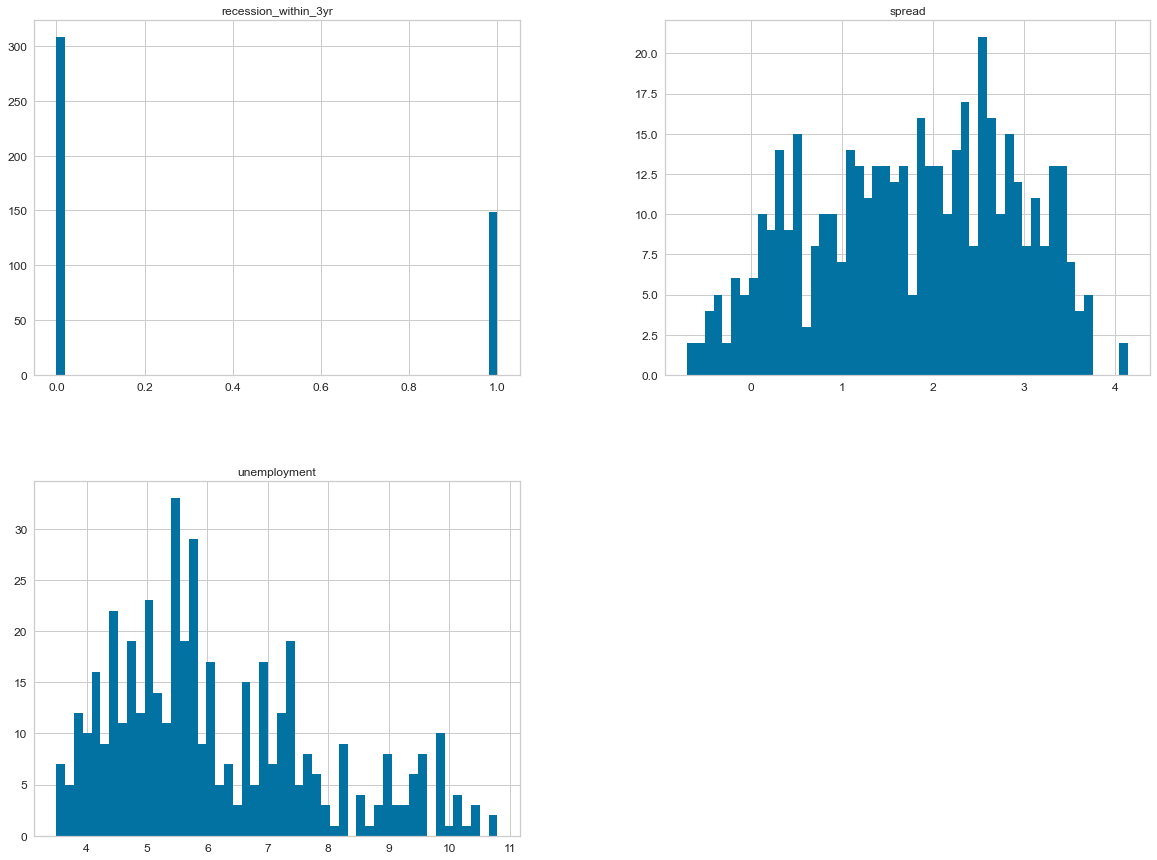

In [29]:
DF_PROCESSED[attributes].hist(bins=50, figsize=(20,15))
plt.show()

We see that we have a fairly sizeable amount of both classes of the binary output variable so we do not have to worry too much about sparsity of certain outcomes. 

We see that the spread variable looks normally distributed and therefore the standard deviation is useful to us to get a feel for the spread of observations around the mean. 

We also notice that the unemployment variable is not normally distributed and there is a right skew in the graph, rendering standard deviation less useful. While a distribution of this shape may cause an issue with OLS regression due to the requirement of errors being normally distributed, logistic regression has no such assumption (it does require that observations should be independent, which actually is a potential problem here and would have to be addressed in further analysis using a multilevel longitudinal model). Therefore, we will not have to worry about potentially having to transform this variable to make it appear normal, such as by taking its log or performing a box cox transformation.

Next, let's look at the covariation of the variables with each other using a correlation plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000242B4D03710>,
      dtype=object)

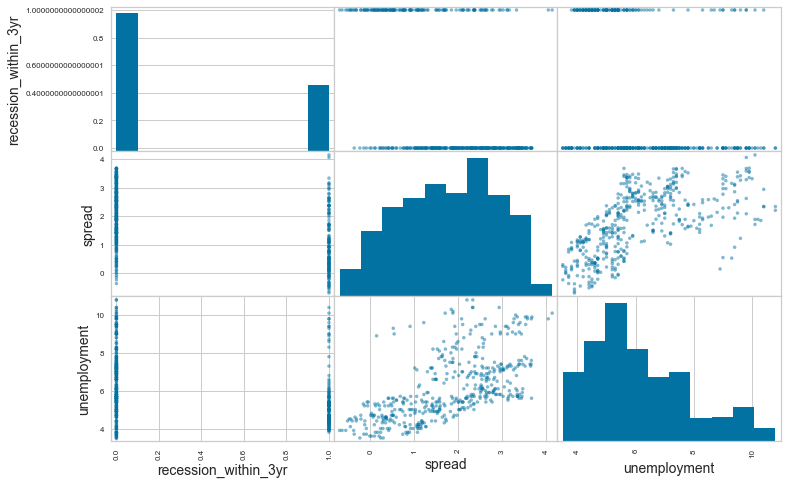

In [30]:
scatter_matrix(DF_PROCESSED[attributes],figsize=(12,8))

Spread and unemployment seem to be very correlated (we can see this by looking at either of the boxes that compare the two variables which show a clear trend of the variables changing in the same direction together). Let's take a closer look at just how correlated these two measures are before we proceed. Two measures that are interesting to look at when assessing collinearity are correlation between the predictor variables and VIF (Variance Inflation Factor), which measures how much the variance of an estimated regression coefficient increases if the predictors are correlated. As a rule of thumb, a correlation higher than .9 is considered high and will severely negatively impact the accuracy/stability of coefficient estimates (Dohoo et al., 1997). When it comes to VIF, values higher than 10 will also have a similar unwanted impact (Lin, 2008). Essentially, we are looking for correlation between predictors to be less than .9 and VIF less than 10, or we cannot trust the regression coefficient estimates.

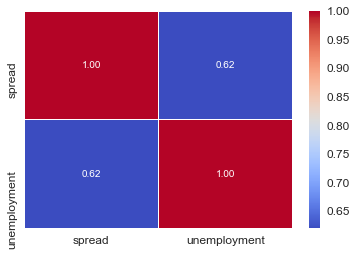

In [31]:
#correlation of predictors heatmap
sns.heatmap(round(DF_PROCESSED[['spread','unemployment']].corr(),2), annot=True,cmap="coolwarm",fmt='.2f',linewidths=.05)

In [32]:
#VIF
pd.Series([variance_inflation_factor(sm.add_constant(DF_PROCESSED[['spread','unemployment']]).values, i) 
               for i in range(sm.add_constant(DF_PROCESSED[['spread','unemployment']]).shape[1])], 
              index=sm.add_constant(DF_PROCESSED[['spread','unemployment']]).columns)[1:3]

spread          1.618857
unemployment    1.618857
dtype: float64

It looks like both correlation (.62) and VIF (1.62) are within the limits we imposed and we will therefore be able to carry out regression analysis without feeling too worried about unstable coefficients. Still, when fitting the predictive model, we will add some regularization which should partially alleviate the negative impact of the collinearity that is present.

It's very hard to see what exactly is going on in the relationship between spread vs recession as well as unemployment vs recession due to the binary nature of the recession variable. In this case, we're going to fit a logistic curve which will give us a better idea by providing us with a curve with probabilities (between 0 and 1) of recession on the y axis (instead of simply binary values of 0 or 1).

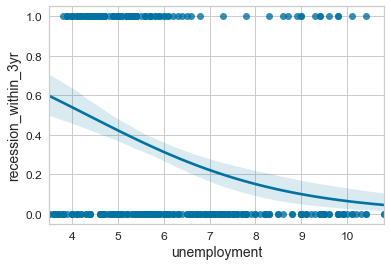

In [33]:
sns.regplot(x='unemployment', y='recession_within_3yr', data=DF_PROCESSED, logistic=True)

Now we can see that, somewhat counterintuitively, the probability of a recession within 3 years increases as unemployment rate goes down.

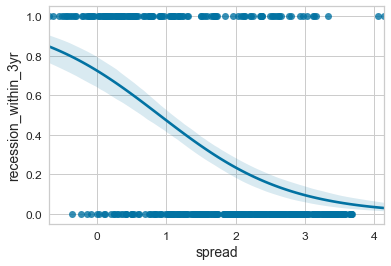

In [34]:
sns.regplot(x='spread', y='recession_within_3yr', data=DF_PROCESSED, logistic=True)

Here, we see that as the yield spread goes down, the probability of a recession goes up.

While we expect that the coefficients of both predictors (unemployment rate and yield spread) should be negative, recall that the two predictors are correlated with each other, and due to that correlation we are going to see some strange things happen once we fit the logistic regression model. At this point, we are done with EDA and are ready to build models. Since we are dealing with classfication, from classical statistics, we will fit a logistic regression. From the machine learning realm, we will employ one of the best tree based methods available, a gradient boosting model from the XGBoost package. We will then compare the performance of the two approaches on a test set.

First, let's set up our data structures, we need an input matrix X made up of our predictors, and an output vector y, which is our outcome variable.

In [35]:
#set up the input (X) matrix and output (y) vector
X = DF_PROCESSED[["unemployment","spread"]]
y = DF_PROCESSED["recession_within_3yr"]


It is a necessary practice to split data into a training and testing set. Since models tend to overfit the data they are trained on (which prevents good generalization performance on new data), we will leave some data to the side and then see how our models perform on it. This will be a better judge of the quality of a model than the misleading (and usually superior) model perfomance on a train set. We will randomly split out 20% of our data for the test set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We should always have a baseline/common sense model to compare more complex models against. In our case, we will have a model that will simply classify every observation to the most frequent class, in this case, no recession. The following code fits the model, and returns predictions from that model. 

While not useful for the baseline model, in order to make "clean predictions" for model evaluation without using our test set, we use the cross_val_predict function. What it does is make predictions from models that never saw the data points being predicted during training. The cross_val_predict function performs k-fold cross-validation, in this case, splitting our training data into 5 pieces, training on 4 and predicting for the 5th, repeating the process 5 times total, as it predicts for each of the 5 folds.

In [37]:
baseline_clf = DummyClassifier(strategy="most_frequent")
baseline_clf.fit(X_train, y_train)
y_baseline_pred = cross_val_predict(baseline_clf,X_train,y_train,cv=5 )

Now, let's take a look at the confusion matrix:

In [38]:
confusion_matrix(y_train,y_baseline_pred)

array([[249,   0],
       [116,   0]], dtype=int64)

The confusion matrix shows our predictions in columns (so, we predicted all 365 observations to have a recession_within_3yr value of 0), while the rows show the actual labels of those observations (there were actually 249 observations with recession_within_3yr value of 0 while 116 observations had a value of 1). While there are many different metrics to look at when evaluating a classifier based on the business problem at hand, let's look at the accuracy rate (correct predictions/all predictions).

In [39]:
baseline_clf.score(X_train, y_train) 

0.6821917808219178

This measure tells us, that at the very least, our complex models have to beat an accuracy rate of 68%.

Let's start with a logistic model fit. The statsmodels.api provides a few more helpful statistical measures than scikit learn (which we will use later since it has some useful functions and integrates well with some complementary packages), so let's fit the multivariate logistic regression using statsmodels.api first.

In [40]:
X_train_constant = sm.add_constant(X_train)
logit_mod = sm.Logit(y_train,X_train_constant)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.491939
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     recession_within_3yr   No. Observations:                  365
Model:                            Logit   Df Residuals:                      362
Method:                             MLE   Df Model:                            2
Date:                  Thu, 28 May 2020   Pseudo R-squ.:                  0.2132
Time:                          16:24:59   Log-Likelihood:                -179.56
converged:                         True   LL-Null:                       -228.20
Covariance Type:              nonrobust   LLR p-value:                 7.496e-22
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0131      0.490      2.067      0.039       0.053       1.974
unemplo

Now, we've come to the surprising part I mentioned earlier. Recall that when we looked at individual predictors vs the outcome variable during EDA, we saw that both predictors clearly had a negative coefficient, meaning, a decrease in unemployment rate or yield spread should lead to a higher probability of a recession. Here, on the other hand, we see that while yield spread still has a negative coefficient, the sign for unemployment rate flipped, and it is actually very close to 0 with the confidence interval (0.01 +- .097) actually containing 0. The way to interpret this phenomenon is: when we control for yield spread by including it in the model along with unemployment, our data do not enable us to confidentally determine the direction of the unemployment effect and its magnitude is limited. We could pull this predictor out of the model at this point, but I leave it in for a consistent comparison to the XGBoost model which performs better when it's included (perhaps due to a nonlinear relationship/effect the XGBoost model finds that our simple logistic regression model cannot).



OK, now let's use scikit learn to fit a regularized logistic regression. This type of regularization is called ridge, and it essentially penalizes high coefficient values. By doing this, we both reduce the effects of multicollinearity (correlated predictors), as well as reduce overfitting and improve the model's performance on data it has not seen yet.

In [41]:
LogReg = LogisticRegression(penalty='l2')
LogReg.fit(X_train,y_train)
LogReg_train_pred = cross_val_predict(LogReg,X_train,y_train,cv=5 )

Let's take a look at the confusion matrix and accuracy score:

In [42]:
confusion_matrix(y_train,LogReg_train_pred)

array([[222,  27],
       [ 52,  64]], dtype=int64)

In [43]:
LogReg.score(X_train, y_train) 

0.7890410958904109

It looks like our model improved over the baseline model by a little over 10%! Next, let's take a look at the ROC curve. 

The ROC curve tells us about the overall diagnostic ability of a classifier. For example, if we want to catch as many recessions as we can without worrying that we're classifying some datapoints that are not recessions as recessions (increasing the True Positive Rate at the cost of the False Positive Rate), we would move to the right on the ROC curve. If, on the other hand, we don't want to make mistakes when we classify recessions and we're OK with some actual recessions not being classified as such (decrease our False Positive Rate at the cost of True Positive Rate), we would move to the left on the curve. Another way to think about the ROC curve is the x-axis represents the type 1 error rate, while the y-axis represents the power of the statistical test.

Keep in mind, that moving up or down the curve is not a reflection of the classifier, it's just a way to tune it for the problem we want to solve. The measure of the classifier itself that we can compare against other classifiers is the area under the ROC curve (aka, AUC). The closer the AUC is to 1, the better our model is at separating the positive classes from negative. A model with an AUC of .5, is no better than random guessing. OK, now let's take a look:

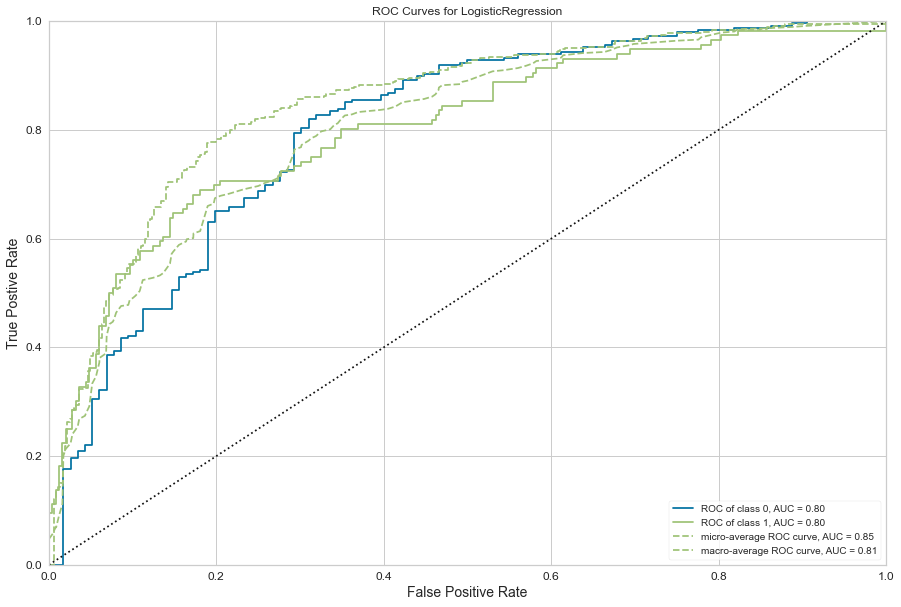

In [44]:
#Logistic Regression Train Set AUC
rocauc_logreg = ROCAUC(LogReg,size=(1080,720))
rocauc_logreg.score(X_train, y_train)
r_logreg = rocauc_logreg.poof()

The AUC of our model on the training dataset is about .8, which is better than a random classifier which has an AUC of .5, but it's still a bit under 1 (perfect classifier). Let's see if we can do any better by modeling the data using a gradient boosted model.

Gradient Boosting algorithms are one of the best tree based ensemble methods from the machine learning realm and they can handle both regression and classification tasks. The details are outside the purpose of this analysis, but the core principle is they sequentially fit simple decision trees with each subsequent tree fitting to the error of the previous decision tree. 

We are going to fit a gradient boosting classifier with low max_depth (controls size of decision trees), early_stopping_rounds (this parameter helps select the inflection point where performance on the train set continues to increase while performance on the test set starts to decrease when looking at the AUC value) and a new evaluation/test set (broken out from our train set so we don't use the actual test data yet). These steps are done to prevent overfitting and ensure good generalization of the model to the true test set.

In [45]:
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

XGBClass = xgboost.XGBClassifier(max_depth=3,objective = 'binary:logistic')
XGBClass.fit(X_train_XGB,y_train_XGB,eval_set=[(X_test_XGB,y_test_XGB)],eval_metric= 'auc', early_stopping_rounds=20,verbose = 0)
XGBClass_train_pred = XGBClass.predict(X_train)

We can look at which features were deemed important by our algorithm:

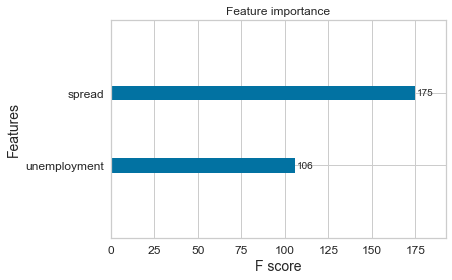

In [46]:
xgboost.plot_importance(XGBClass)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


It looks like both features have some discriminative power (represented by the F-score), but it looks like the yield spread carries a bit more information than unemployment when trying to predict a recession. It's interesting to note that while our logistic regression model did not seem to allocate any effect to unemployment as a feature in the model (when spread was included as a feature), the XGBoost model did. Now, let's look at the confusion matrix and accuracy of XGBoost on the training data:

In [47]:
confusion_matrix(y_train,XGBClass_train_pred)

array([[244,   5],
       [ 38,  78]], dtype=int64)

In [48]:
XGBClass.score(X_train, y_train)

0.8821917808219178

We've achieved 88% accuracy, which looks 10% better than our logistic regression (and 20% better than our dummy classifier). Now let's look at the ROC AUC:

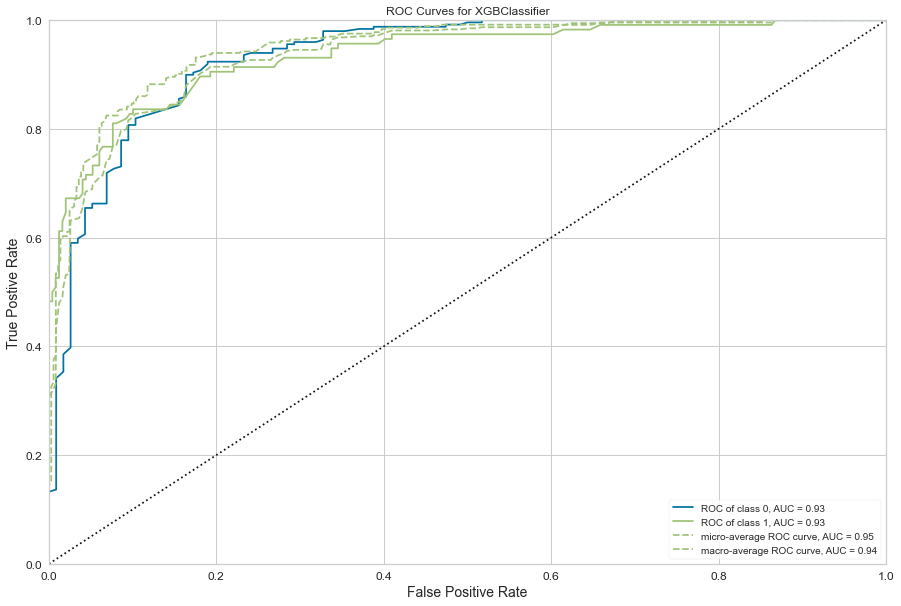

In [49]:
#XGBoost Train Set AUC
rocauc = ROCAUC(XGBClass,size=(1080,720))
rocauc.score(X_train, y_train)
r = rocauc.poof()

Here too, our AUC is about .93, compared to the AUC of .8 of our logistic model. So far, it looks like XGBoost is performing better than Logistic Regresison (though at a cost to interpretability and lack of straightforward measures such as effect size which we have from regression based methods). The next step is to finally evaluate our models on the test sets. We will look at the accuracy rate and ROC curve of the Logistic Regression model, followed by XGBoost.

In [50]:
LogReg.score(X_test, y_test)

0.7391304347826086

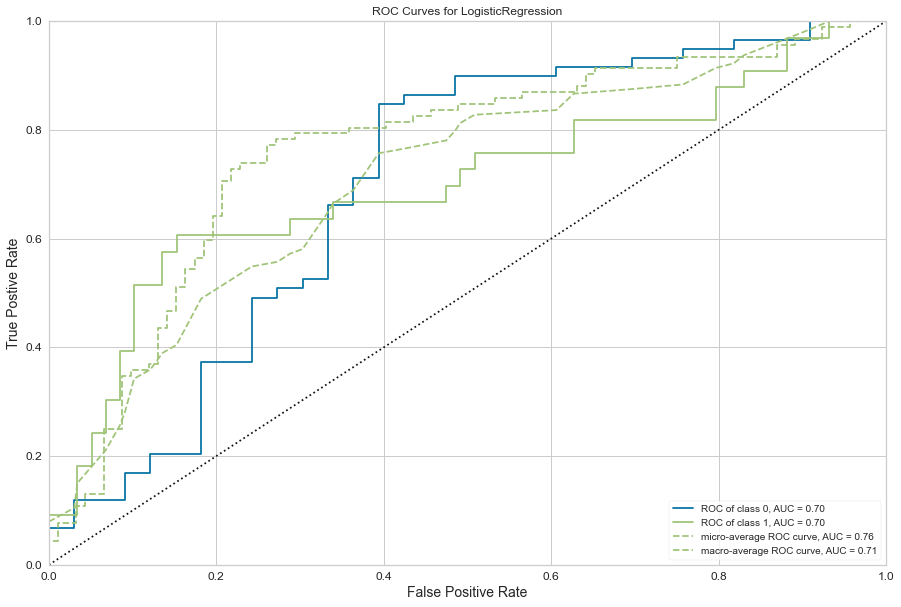

In [51]:
rocauc_LogReg_test = ROCAUC(LogReg,size=(1080,720))
rocauc_LogReg_test.score(X_test, y_test)
r = rocauc_LogReg_test.poof()

In [52]:
XGBClass.score(X_test, y_test)

0.8043478260869565

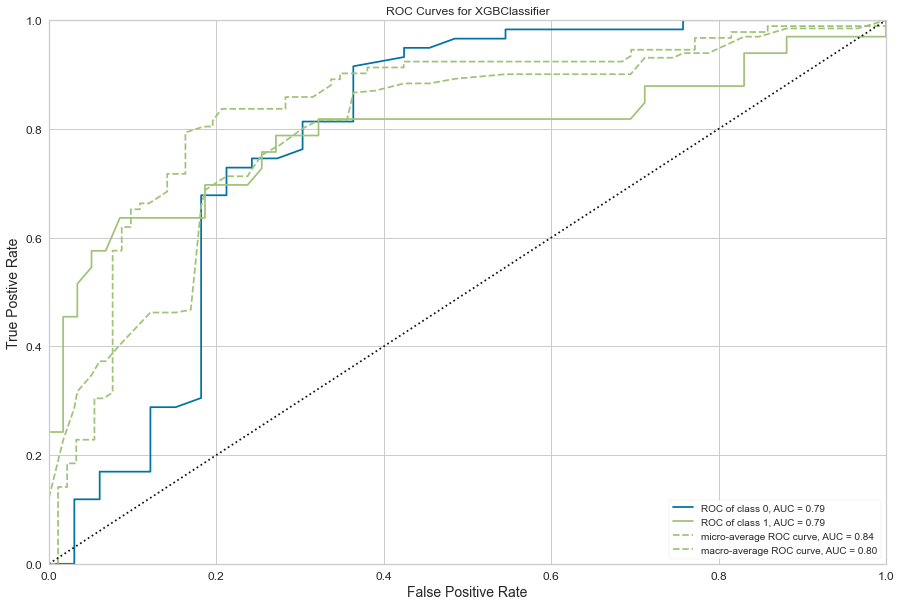

In [53]:
rocauc_XGB_test = ROCAUC(XGBClass,size=(1080,720))
rocauc_XGB_test.score(X_test, y_test)
r = rocauc_XGB_test.poof()

Here, we see the effect very common in statistics and machine learning, that is, the performance on the unseen test set is inferior to the training set due to overfitting. The logistic model's accuracy went from .79 to .74 and an AUC of .8 to an AUC of .7, while XGBoost went from an accuracy of .88 to .8 and an AUC of .93 down to .79. At the end of the day, the quality and amount of training data (both observations/rows and features/columns), has a huge effect on the quality and generalization performance of models. Still, both models performed admirably given only a couple of economic indicators and observations starting in 1982, achieving accuracy rates of .74 and .8 on unseen data. Furthermore, the Logistic model should be extended to account for the nonindependence of observations which should improve that model further. In particular, subsequent months are certainly not independent of each other and therefore require a multilevel longitudinal model to address this. I would attempt this as the next step if I wanted to keep working on the Logistic classifier (which I might do in the future). 

Hope you enjoyed reading, feel free to let me know what you thought!